# Lecture 8 - Neural Networks

```{contents}
:local:
:depth: 1
```

## Learning goals

- Explain a simple multilayer perceptron: layers, weights, bias, activation, loss, optimizer.
- Build your first neural network for a toy problem, then for small chemistry tasks.
- Train `MLPRegressor` and `MLPClassifier` step by step with diagnostics.
- Read training curves, avoid overfitting.

[![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/14-maUiOWGRvYAG04Y2gGsSTnDHS_x6Z-?usp=sharing)

---

## 0. Setup

We will stick to a light stack so it runs everywhere.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, roc_curve)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor

# RDKit optional
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
except Exception:
    Chem = None

---

## 1. What is a neural network

```{admonition} Picture in words
A multilayer perceptron (MLP) takes an input vector x, multiplies by a weight matrix, adds a bias, applies a nonlinear activation like ReLU or tanh, then repeats for one or more hidden layers, and finally outputs a number (regression) or class score (classification).
```

Key pieces:

- **Weights `W` and bias `b`** set how features combine.
- **Activation** makes the model nonlinear so it can bend decision boundaries.
- **Loss** measures error. We update weights to reduce loss on the training set.
- **Optimizer** uses gradients to move weights a little bit each iteration (epoch).

We start tiny with a simulated dataset so we can see each piece clearly.

### 1.1 Generate a toy dataset and plot

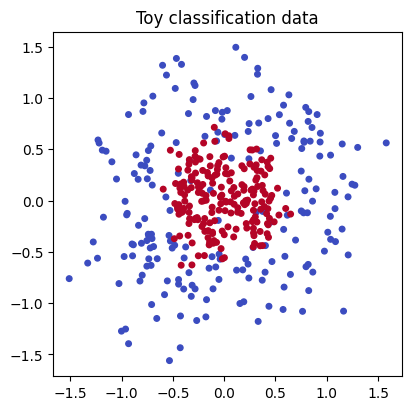

In [2]:
rng = np.random.RandomState(0)

n = 200
theta = rng.uniform(0, 2*np.pi, size=n)
r = 1.0 + 0.3*rng.randn(n)
X1 = np.c_[r*np.cos(theta), r*np.sin(theta)]
y1 = np.zeros(n, dtype=int)

theta2 = rng.uniform(0, 2*np.pi, size=n)
r2 = 0.4 + 0.15*rng.randn(n)
X2 = np.c_[r2*np.cos(theta2), r2*np.sin(theta2)]
y2 = np.ones(n, dtype=int)

X_toy = np.vstack([X1, X2])
y_toy = np.hstack([y1, y2])

plt.figure(figsize=(4.5,4.5))
plt.scatter(X_toy[:,0], X_toy[:,1], c=y_toy, cmap="coolwarm", s=16)
plt.gca().set_aspect("equal")
plt.title("Toy classification data")
plt.show()

### 1.2 Split and try a linear model

```{admonition} Why a baseline
As in past lectures, a simple baseline tells us if a complex model is truly needed.
```
In scikit-learn, a **pipeline** is a convenient way to chain multiple steps together into a single object.  
Here, our pipeline has two steps:

1. **Scaler (`StandardScaler`)**: ensures each feature has zero mean and unit variance, which helps many models train more effectively.  
2. **Logistic Regression (`LogisticRegression`)**: the actual linear classifier that fits a straight decision boundary to the data.

In our toy dataset, both `x` and `y` coordinates are on a similar numeric scale (roughly between -1.5 and 1.5). That means the results will look similar with or without the scaler. Still, you can see the first example has a higher acc `0.56` than the second one `0.54`, and including it is good practice, because real-world datasets often have features on very different scales.

In [3]:
Xtr, Xte, ytr, yte = train_test_split(X_toy, y_toy, test_size=0.25, random_state=42, stratify=y_toy)

lin = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])
lin.fit(Xtr, ytr)

acc_lin = accuracy_score(yte, lin.predict(Xte))
print(f"Linear baseline accuracy with sacler: {acc_lin:.3f}")

Linear baseline accuracy with sacler: 0.520


By wrapping these steps in a pipeline, we can train, evaluate, and later reuse the combined process as if it were one model.

Without scaler, the result will be different in this dataset:

In [4]:
Xtr, Xte, ytr, yte = train_test_split(X_toy, y_toy, test_size=0.25, random_state=42, stratify=y_toy)

lin2 = LogisticRegression(max_iter=1000)
lin2.fit(Xtr, ytr)

acc_lin2 = accuracy_score(yte, lin2.predict(Xte))
print(f"Linear baseline accuracy without scaler: {acc_lin2:.3f}")

Linear baseline accuracy without scaler: 0.520


Regardless, as you can see, currently the prediction is pretty bad because linear regression itself does not handle this type of complex "donut" style dataset well due to its inherent limitation.

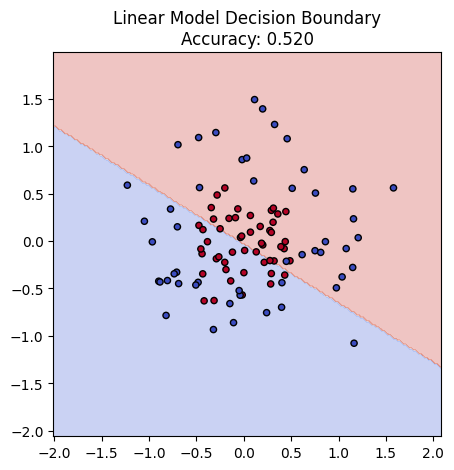

In [5]:
# Visualization of linear model decision boundary
xx, yy = np.meshgrid(
    np.linspace(X_toy[:, 0].min() - 0.5, X_toy[:, 0].max() + 0.5, 200),
    np.linspace(X_toy[:, 1].min() - 0.5, X_toy[:, 1].max() + 0.5, 200)
)

Z = lin.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(5,5))
plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)
plt.scatter(Xte[:, 0], Xte[:, 1], c=yte, cmap="coolwarm", s=20, edgecolor="k")
plt.gca().set_aspect("equal")
plt.title(f"Linear Model Decision Boundary\nAccuracy: {acc_lin:.3f}")
plt.show()

### 1.3 Build a small MLP step by step



Now let's see if we can solve this classification challenge with simple and shallow neural network.

We will build a MLP classifier by adding one hidden layer with 8 units and ReLU activation. Before we start to do it, we will first look at key concepts:



A multilayer perceptron (MLP) stacks simple building blocks:

- **Linear layer**: multiply by weights and add a bias. Example: `z = X @ W + b`
- **Activation**: bend the space so a straight line can become a curve. Common choices:
  - ReLU: `max(0, z)`  
  - Tanh: squashes to `[-1, 1]`  
  - Sigmoid: squashes to `[0, 1]` and is often used at the output for probability
- **Loss**: tells us how wrong we are. For classification we use cross entropy
- **Optimizer**: updates weights to reduce loss. Scikit-learn’s MLP uses SGD variants under the hood

Why ReLU
- It is simple, fast, and avoids the flat gradients that slow learning with sigmoid on hidden layers
- Many ReLU units stacked together can carve a curved boundary that a linear model cannot

Below we first look at the shapes of common activations, then we build a small MLP and read its learned shapes.

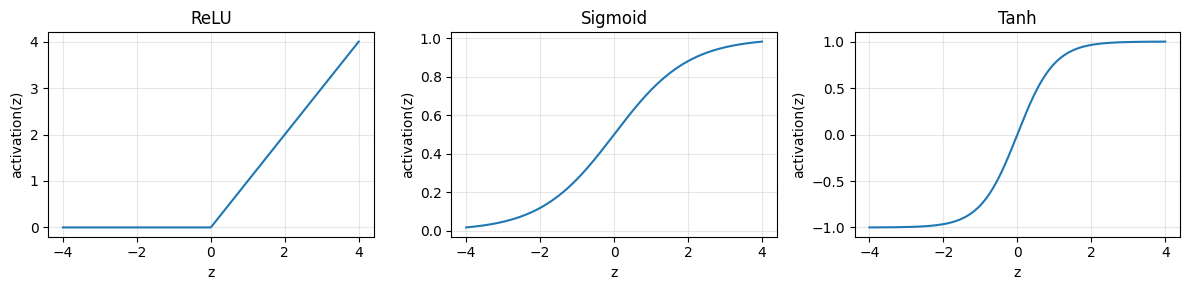

In [6]:
# Mini gallery of activation functions in three panels
x = np.linspace(-4, 4, 400)

def relu(z):     return np.maximum(0, z)
def sigmoid(z):  return 1 / (1 + np.exp(-z))
def tanh_act(z): return np.tanh(z)

fig, axes = plt.subplots(1, 3, figsize=(12,3))

axes[0].plot(x, relu(x))
axes[0].set_title("ReLU")
axes[0].grid(alpha=0.3)

axes[1].plot(x, sigmoid(x))
axes[1].set_title("Sigmoid")
axes[1].grid(alpha=0.3)

axes[2].plot(x, tanh_act(x))
axes[2].set_title("Tanh")
axes[2].grid(alpha=0.3)

for ax in axes:
    ax.set_xlabel("z")
    ax.set_ylabel("activation(z)")

plt.tight_layout()
plt.show()

To keep it simple, imagine we have just **one input $x$**, two hidden ReLU units, and one sigmoid output.

```{admonition} Note


Steps:

1. Hidden pre-activations  
$$
z^{(1)}_1 = w^{(1)}_{1}\,x + b^{(1)}_{1}, 
\quad
z^{(1)}_2 = w^{(1)}_{2}\,x + b^{(1)}_{2}
$$

2. Hidden activations (apply ReLU)  
$$
h_1 = \max(0, z^{(1)}_1), 
\quad
h_2 = \max(0, z^{(1)}_2)
$$

3. Output score and probability  
$$
z^{(2)} = v_{1} h_1 + v_{2} h_2 + b^{(2)}, 
\quad
\hat{p} = \sigma(z^{(2)}) = \frac{1}{1 + e^{-z^{(2)}}}
$$
```

During training, the model learns weights 
$w^{(1)}_{1}, w^{(1)}_{2}, v_1, v_2$ and biases $b^{(1)}_{1}, b^{(1)}_{2}, b^{(2)}$ to minimize classification error.

---------------------------
Let's look at one example with numbers so it's easier to understand:

Suppose:
- Input: $x = 0.5$  
- Hidden weights and biases:  
  $w^{(1)}_{1} = 2.0,\; b^{(1)}_{1} = -0.6$  
  $w^{(1)}_{2} = -1.0,\; b^{(1)}_{2} = 0.2$  
- Output weights and bias:  
  $v_1 = 1.0,\; v_2 = -2.0,\; b^{(2)} = 0.1$

**Step 1. Hidden pre-activations**  
$$
z^{(1)}_1 = 2.0 \cdot 0.5 + (-0.6) = 0.4
$$
$$
z^{(1)}_2 = -1.0 \cdot 0.5 + 0.2 = -0.3
$$

**Step 2. Hidden activations (ReLU)**  
$$
h_1 = \max(0, 0.4) = 0.4
$$
$$
h_2 = \max(0, -0.3) = 0
$$

**Step 3. Output**  
$$
z^{(2)} = 1.0 \cdot 0.4 + (-2.0) \cdot 0 + 0.1 = 0.5
$$
$$
\hat{p} = \sigma(0.5) = \frac{1}{1+e^{-0.5}} \approx 0.62
$$

So with this set of weights, input $x=0.5$ is classified with probability $\hat{p} \approx 0.62$ for class 1.

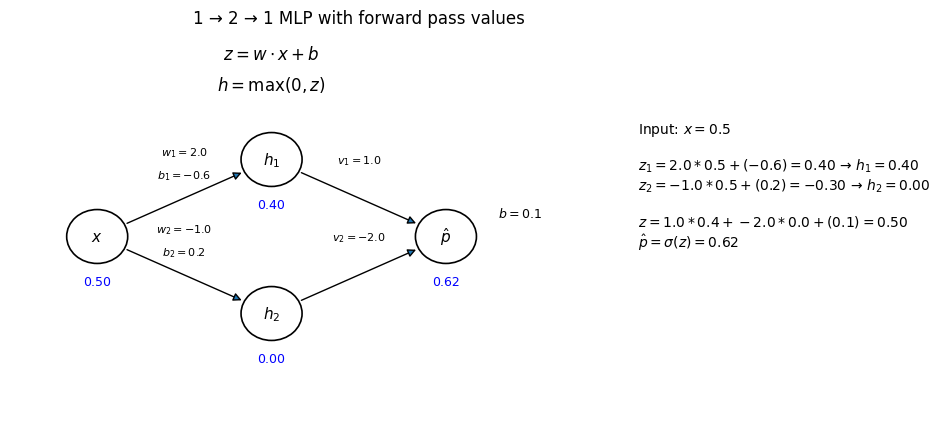

In [7]:
from matplotlib.patches import Circle, FancyArrowPatch

# --- example parameters ---
x = 0.5
w1, b1 = 2.0, -0.6   # hidden 1
w2, b2 = -1.0, 0.2   # hidden 2
v1, v2, b_out = 1.0, -2.0, 0.1  # output

# --- forward pass ---
z1 = w1*x + b1
z2 = w2*x + b2
h1, h2 = relu(z1), relu(z2)
z_out = v1*h1 + v2*h2 + b_out
p_hat = sigmoid(z_out)

# --- node positions ---
nodes = {
    "x": (0, 0),
    "h1": (2, 1),
    "h2": (2, -1),
    "y": (4, 0),
}

def draw_node(ax, name, label, value=None, radius=0.35):
    cx, cy = nodes[name]
    c = Circle((cx, cy), radius, fc="white", ec="k", lw=1.2)
    ax.add_patch(c)
    ax.text(cx, cy, label, ha="center", va="center", fontsize=11)
    if value is not None:
        ax.text(cx, cy - radius - 0.15, f"{value:.2f}", 
                ha="center", va="top", fontsize=9, color="blue")

def draw_arrow(ax, a, b, lbl_top, lbl_bottom, radius=0.35, y_offset=0.45):
    (x1, y1), (x2, y2) = nodes[a], nodes[b]
    dx, dy = x2 - x1, y2 - y1
    dist = np.sqrt(dx**2 + dy**2)
    shrink = radius / dist
    start = (x1 + dx*shrink, y1 + dy*shrink)
    end   = (x2 - dx*shrink, y2 - dy*shrink)
    arrow = FancyArrowPatch(start, end, arrowstyle="-|>", mutation_scale=12, lw=1.0)
    ax.add_patch(arrow)
    xm, ym = (start[0]+end[0])/2, (start[1]+end[1])/2
    ax.text(xm, ym+y_offset, lbl_top, fontsize=8, ha="center")
    ax.text(xm, ym+y_offset-0.3, lbl_bottom, fontsize=8, ha="center")

# --- make plot ---
fig, ax = plt.subplots(figsize=(9,5))

# generic formulas at top (just linear + ReLU now)
ax.text(2, 2.3, r"$z = w \cdot x + b$", fontsize=12, ha="center")
ax.text(2, 1.9, r"$h = \max(0, z)$", fontsize=12, ha="center")

# nodes with values
draw_node(ax, "x", "$x$", x)
draw_node(ax, "h1", "$h_1$", h1)
draw_node(ax, "h2", "$h_2$", h2)
draw_node(ax, "y", "$\\hat{p}$", p_hat)

# arrows input→hidden (weights and biases on two lines, moved up a bit)
draw_arrow(ax, "x", "h1", f"$w_1={w1}$", f"$b_1={b1}$", y_offset=0.55)
draw_arrow(ax, "x", "h2", f"$w_2={w2}$", f"$b_2={b2}$", y_offset=0.55)

# arrows hidden→output (bias shown near output node)
draw_arrow(ax, "h1", "y", f"$v_1={v1}$", "", y_offset=0.45)
draw_arrow(ax, "h2", "y", f"$v_2={v2}$", "", y_offset=0.45)
ax.text(nodes["y"][0]+0.6, nodes["y"][1]+0.25, f"$b={b_out}$", fontsize=9)

ax.set_xlim(-1, 7)
ax.set_ylim(-2.5, 2.5)
ax.axis("off")
ax.set_title("1 → 2 → 1 MLP with forward pass values", pad=15)

# side text with detailed calculations
text = (
    f"Input: $x={x}$\n\n"
    f"$z_1 = {w1}*{x}+({b1}) = {z1:.2f}$ → $h_1 = {h1:.2f}$\n"
    f"$z_2 = {w2}*{x}+({b2}) = {z2:.2f}$ → $h_2 = {h2:.2f}$\n\n"
    f"$z = {v1}*{h1}+{v2}*{h2}+({b_out}) = {z_out:.2f}$\n"
    f"$\\hat p = \\sigma(z) = {p_hat:.2f}$"
)
ax.text(6.2, 1.5, text, fontsize=10, va="top")

plt.show()

Note that in above example we already have a set of paramters so the calculation can be demonstrated.

In a real neural network, the weights $w$ and biases $b$ are **not chosen by hand**.


So, *where do these numbers come from*?

Try to recall what happens in **linear regression**.  
In that case, you can compute the exact formulas for $w$ and $b$ by hand using sums and algebra or use `lin.fit(Xtr, ytr)` to get your trained function.

In a **neural network**, you usually don’t solve directly with formulas. Instead, you:

1. **Initialize** $w$ and $b$ randomly.  
2. **Adjust them** step by step so that the **loss** (for example, mean squared error or cross-entropy) becomes smaller.  
3. Run the next iteration with the updated weights, check the loss again, and adjust $w$ and $b$ further to aim for an even smaller loss.  
4. After many updates, the parameters $w$ and $b$ converge to useful values — often close to what you would get from regression formulas in simple cases.

Because this process is iterative, the real learned numbers can look irregular, like $w=0.483$ or $b=-1.273$.  
For teaching, we instead pick **round numbers** so it’s easier to see the flow of calculations by hand.

In [8]:
mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(hidden_layer_sizes=(8,),
                          activation="relu",
                          learning_rate_init=0.05,
                          alpha=1e-4,            # L2 penalty
                          max_iter=500,
                          random_state=0))
])
mlp

,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,hidden_layer_sizes,"(8,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001


Fit and evaluate.

In [9]:
mlp.fit(Xtr, ytr)
acc_mlp = accuracy_score(yte, mlp.predict(Xte))
print(f"MLP accuracy: {acc_mlp:.3f}")

MLP accuracy: 0.940


Compared with linear regression (`baseline accuracy: 0.560`), we now get an `MLP accuracy: 0.870`, which is much higher!

### 1.5 Analyzing the MLP models

Now let's look at the plot below to see the structure of the MLP model we built.

Remember, we have 5 input `x` features. In the earlier plot we only showed the first two (X–Y) for visualization, but each point actually comes from all 5 features — that 2D scatter is just a projection. Think back to the earlier lecture where a molecule could be represented by multiple features such as `MolWt`, `LogP`, etc. In the same way, here all 5 features are connected to the hidden layer (with 5 units in this example).

Number of layers (including input and output): 3
Hidden layer sizes: (8,)
coefs_ length (weight matrices between layers): 2
Layer 1 weight shape: (2, 8)   bias shape: (8,)
Layer 2 weight shape: (8, 1)   bias shape: (1,)


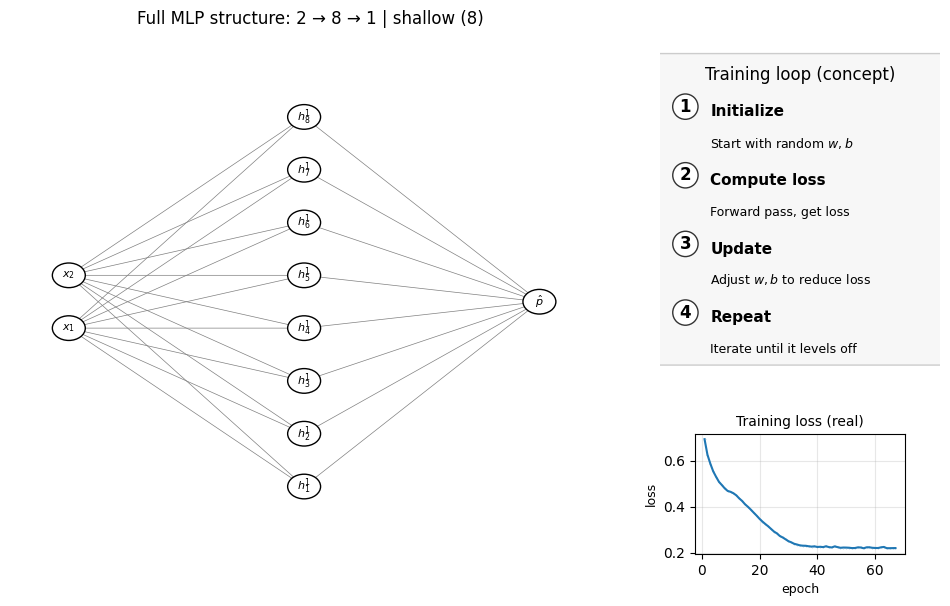

In [10]:
from matplotlib.patches import Circle, FancyArrowPatch, FancyBboxPatch
def summarize_mlp(mlp_pipeline):
    clf = mlp_pipeline.named_steps["clf"]
    hidden = clf.hidden_layer_sizes if isinstance(clf.hidden_layer_sizes, tuple) else (clf.hidden_layer_sizes,)
    print("Number of layers (including input and output):", clf.n_layers_)
    print("Hidden layer sizes:", hidden)
    print("coefs_ length (weight matrices between layers):", len(clf.coefs_))
    for i, (W, b) in enumerate(zip(clf.coefs_, clf.intercepts_), start=1):
        print(f"Layer {i} weight shape:", W.shape, "  bias shape:", b.shape)

def draw_full_mlp_structure(mlp_pipeline, Xtr, title_suffix=""):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle, FancyArrowPatch, FancyBboxPatch

    clf = mlp_pipeline.named_steps["clf"]
    n_inputs = Xtr.shape[1]
    hidden = clf.hidden_layer_sizes if isinstance(clf.hidden_layer_sizes, tuple) else (clf.hidden_layer_sizes,)
    sizes = [n_inputs] + list(hidden) + [1]

    x_spacing, y_spacing = 2.0, 0.6
    nodes = {}
    for L, width in enumerate(sizes):
        x = L * x_spacing
        ys = [(i - (width-1)/2)*y_spacing for i in range(width)]
        for i, y in enumerate(ys):
            nodes[(L, i)] = (x, y)

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_axes([0.05, 0.06, 0.60, 0.88])
    rx = fig.add_axes([0.70, 0.06, 0.28, 0.88])
    ax.axis("off"); rx.axis("off")

    # Connections
    for L in range(len(sizes)-1):
        for i in range(sizes[L]):
            for j in range(sizes[L+1]):
                start, end = nodes[(L,i)], nodes[(L+1,j)]
                ax.add_patch(FancyArrowPatch(start, end, arrowstyle="-", lw=0.5, color="gray",
                                             connectionstyle="arc3,rad=0"))

    # Nodes
    R = 0.14
    for (L,i), (cx,cy) in nodes.items():
        c = Circle((cx,cy), R, fc="white", ec="k", lw=1)
        ax.add_patch(c)
        if L == 0:
            ax.text(cx, cy, f"$x_{i+1}$", ha="center", va="center", fontsize=8)
        elif L == len(sizes)-1:
            ax.text(cx, cy, "$\\hat p$", ha="center", va="center", fontsize=8)
        else:
            ax.text(cx, cy, f"$h^{L}_{i+1}$", ha="center", va="center", fontsize=8)

    arch = " → ".join([str(s) for s in sizes])
    ax.set_title(f"Full MLP structure: {arch}{(' | ' + title_suffix) if title_suffix else ''}", pad=10)

    # Right panel: steps box
    box = FancyBboxPatch((0.00, 0.40), 1.00, 0.55,
                         boxstyle="round,pad=0.02,rounding_size=0.02",
                         fc="#f7f7f7", ec="#cccccc")
    rx.add_patch(box)
    rx.text(0.50, 0.92, "Training loop (concept)", ha="center", fontsize=12)

    steps = [
        ("1", "Initialize", "Start with random $w, b$"),
        ("2", "Compute loss", "Forward pass, get loss"),
        ("3", "Update", "Adjust $w, b$ to reduce loss"),
        ("4", "Repeat", "Iterate until it levels off"),
    ]
    y0 = 0.86
    for idx, (num, title, line) in enumerate(steps):
        y = y0 - idx*0.13
        rx.text(0.07, y, num, fontsize=12, weight="bold",
                bbox=dict(boxstyle="circle,pad=0.22", fc="#ffffff", ec="#333333"))
        rx.text(0.18, y, title, fontsize=11, weight="bold", va="center")
        rx.text(0.18, y-0.06, line, fontsize=9, va="center")

    # Real loss curve (fallback to mock if unavailable)
    axc = fig.add_axes([0.735, 0.08, 0.21, 0.20])
    loss_curve = getattr(clf, "loss_curve_", None)
    if loss_curve and len(loss_curve) > 0:
        epochs = np.arange(1, len(loss_curve)+1)
        axc.plot(epochs, loss_curve, marker="o", markersize=0.1)
        axc.set_title("Training loss (real)", fontsize=10)
    else:
        print("Mock loss curve only")
        epochs = np.array([0, 1, 2, 5, 20, 50, 100])
        loss =   np.array([1.2, 0.95, 0.78, 0.55, 0.36, 0.31, 0.30])
        axc.plot(epochs, loss, marker="o", markersize=1)
        axc.set_title("Training loss (mock)", fontsize=1)

    axc.set_xlabel("epoch", fontsize=9)
    axc.set_ylabel("loss", fontsize=9)
    axc.grid(alpha=0.3)

    ax.set_xlim(-0.5, x_spacing*(len(sizes)-1)+0.6)
    ax.set_ylim(-max(sizes)/2*y_spacing-0.6, max(sizes)/2*y_spacing+0.6)
    plt.show()

mlp_shallow = mlp 
summarize_mlp(mlp_shallow); draw_full_mlp_structure(mlp_shallow, Xtr, "shallow (8)")



Does it mean that the more complex the MLP, the better results we can? Well, not necessaily. Look at the examlple below, where instead of just 1 layer we have **3 hidden layers** (4 layers in total including the final output layer):

MLP_deep accuracy: 0.920
Number of layers (including input and output): 5
Hidden layer sizes: (8, 5, 3)
coefs_ length (weight matrices between layers): 4
Layer 1 weight shape: (2, 8)   bias shape: (8,)
Layer 2 weight shape: (8, 5)   bias shape: (5,)
Layer 3 weight shape: (5, 3)   bias shape: (3,)
Layer 4 weight shape: (3, 1)   bias shape: (1,)


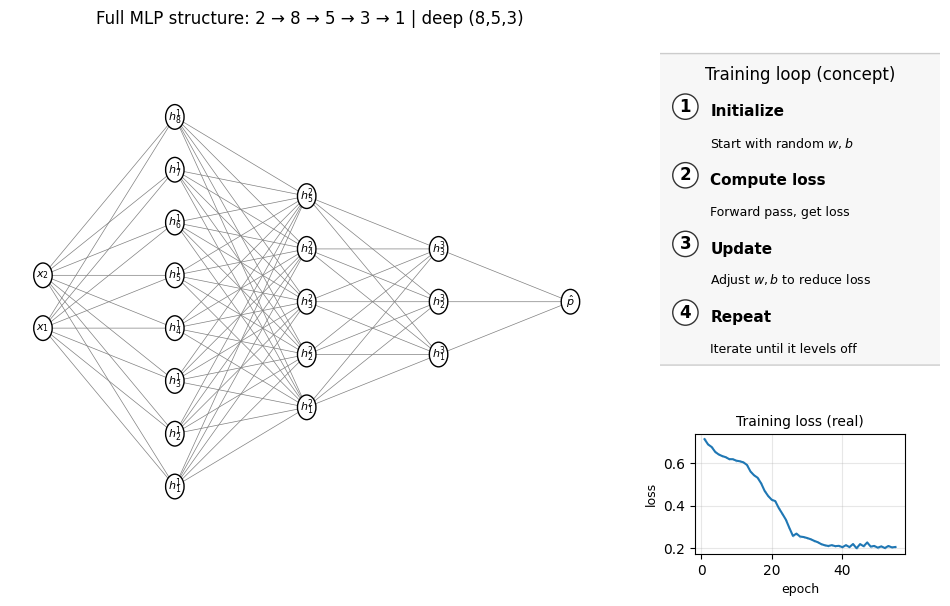

In [11]:
mlp_deep = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(hidden_layer_sizes=(8,5,3),
                          activation="relu",
                          learning_rate_init=0.05,
                          max_iter=500,
                          random_state=0))
])

mlp_deep.fit(Xtr, ytr)
acc_mlp_deep = accuracy_score(yte, mlp_deep.predict(Xte))
print(f"MLP_deep accuracy: {acc_mlp_deep:.3f}")
summarize_mlp(mlp_deep);    draw_full_mlp_structure(mlp_deep, Xtr, "deep (8,5,3)")

The accuray actually drops down! If you look at the loss function above, it's also worse than the simple 5-5-1 shallow MLP we showed as the first example. Just recall the decision tree lecture we had before, the lesson is that you can't just make super complex model to increase the accuracy because the overfitting issue will come at a certain point.

But it doesn't necessarily mean we shouldn't do it. Below is another case and we actually achieve a higher performance.

MLP_deep_2 accuracy: 0.910
Number of layers (including input and output): 6
Hidden layer sizes: (8, 4, 6, 4)
coefs_ length (weight matrices between layers): 5
Layer 1 weight shape: (2, 8)   bias shape: (8,)
Layer 2 weight shape: (8, 4)   bias shape: (4,)
Layer 3 weight shape: (4, 6)   bias shape: (6,)
Layer 4 weight shape: (6, 4)   bias shape: (4,)
Layer 5 weight shape: (4, 1)   bias shape: (1,)


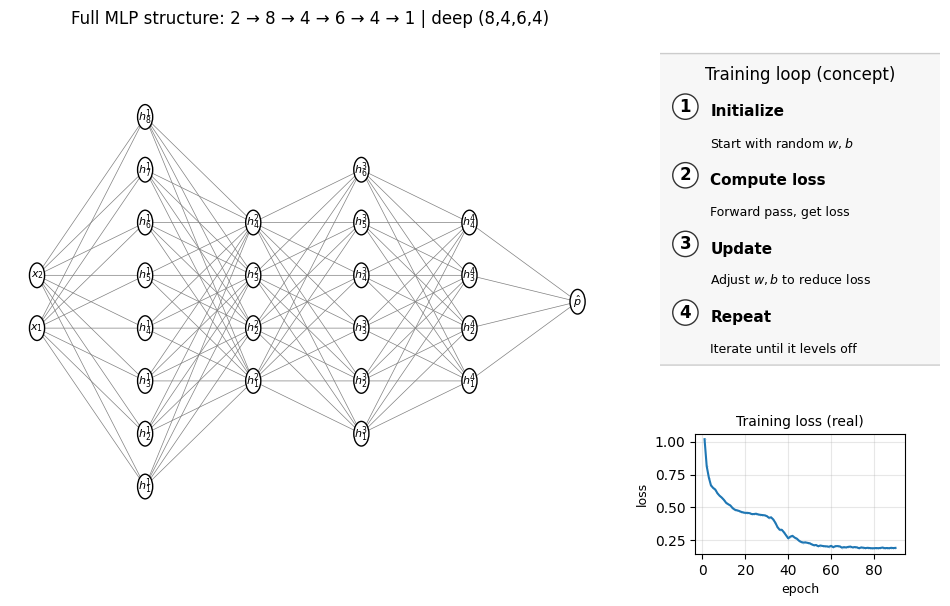

In [12]:
mlp_deep_2 = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(hidden_layer_sizes=(8,4,6,4),
                          activation="relu",
                          learning_rate_init=0.05,
                          max_iter=500,
                          random_state=0))
])

mlp_deep_2.fit(Xtr, ytr)
acc_mlp_deep_2 = accuracy_score(yte, mlp_deep_2.predict(Xte))
print(f"MLP_deep_2 accuracy: {acc_mlp_deep_2:.3f}")
summarize_mlp(mlp_deep_2);    draw_full_mlp_structure(mlp_deep_2, Xtr, "deep (8,4,6,4)")

### 1.6 Decision surface
We can plot a decision surface to see the boundary and compare all these three models.

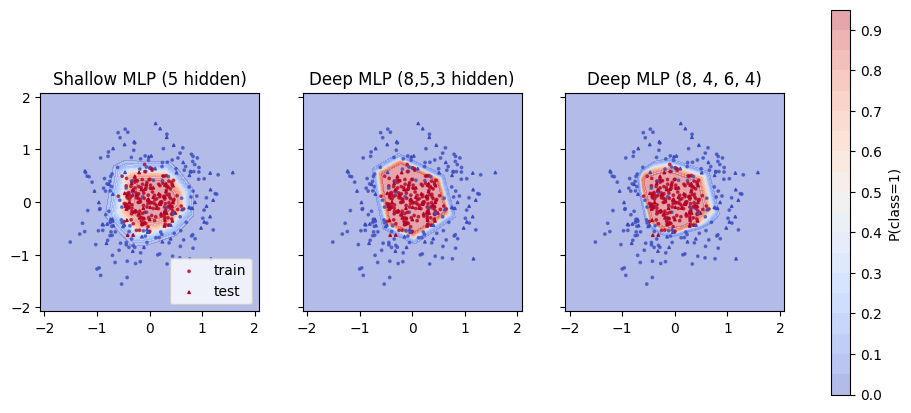

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# square limits from the first two columns
lim = np.abs(np.vstack([Xtr[:, :2], Xte[:, :2]])).max()
pad = 0.5
xs = np.linspace(-lim - pad, lim + pad, 300)
ys = np.linspace(-lim - pad, lim + pad, 300)
xx, yy = np.meshgrid(xs, ys)

# 2D grid for the first two features
grid2 = np.c_[xx.ravel(), yy.ravel()]

# fill the remaining features with training means (raw space)
if Xtr.shape[1] > 2:
    rest_means = Xtr[:, 2:].mean(axis=0)                 # shape (3,)
    rest = np.tile(rest_means, (grid2.shape[0], 1))      # shape (N, 3)
    grid_full = np.hstack([grid2, rest])                 # shape (N, 5)
else:
    grid_full = grid2

# probabilities for both models
zz_shallow = mlp.predict_proba(grid_full)[:, 1].reshape(xx.shape)
zz_deep    = mlp_deep.predict_proba(grid_full)[:, 1].reshape(xx.shape)
zz_deep_2  = mlp_deep_2.predict_proba(grid_full)[:, 1].reshape(xx.shape)

# plot side by side
fig, axes = plt.subplots(1, 3, figsize=(12,5), sharex=True, sharey=True)

for ax, zz, title in zip(
    axes,
    [zz_shallow, zz_deep, zz_deep_2],
    ["Shallow MLP (5 hidden)", "Deep MLP (8,5,3 hidden)", "Deep MLP (8, 4, 6, 4)"]
):
    cs = ax.contourf(xx, yy, zz, levels=20, alpha=0.4, cmap="coolwarm")  # 50% transparency
    ax.scatter(Xtr[:,0], Xtr[:,1], c=ytr, cmap="coolwarm", s=3,  alpha=0.7, label="train")
    ax.scatter(Xte[:,0], Xte[:,1], c=yte, cmap="coolwarm", s=3, marker="^", label="test")
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(title)

fig.colorbar(cs, ax=axes, label="P(class=1)")
axes[0].legend(loc="lower right")
plt.show()


Color near 0 is class 0 and near 1 is class 1. A curved boundary shows that the hidden layer and activation created a nonlinear rule.



```{admonition} ⏰ Exercises 1

1. Change `hidden_layer_sizes=(16,)` then `(16,8)` and compare test accuracy.
2. Switch `activation` from `"relu"` to `"tanh"` and rerun. Which works better here and why might that be?
3. Change `learning_rate_init` to `0.005` then `0.2`. Watch whether the model converges. If it stalls, raise `max_iter`.
4. Remove the scaler from the pipeline and fit again. Record the accuracy. What changed?



```

### 1.7 Hyperparamter tuning

As we see in previous lectures, we can use **cross-validation** to search for the best hyperparamters. In the MLP example below, to demonstrate this idea, we can try different `layer` choice and `learning rate`. But keep in mind that there are multiple hyperparameters we can also tune. To make the demo simple we just fix most of them.

Below code will take around **2 minutes** to complete, since it's alreay 10 x 4 = 40 choices of hyperparamters.

Fitting 5 folds for each of 80 candidates, totalling 400 fits



Best CV accuracy: 0.920
Best params: {'clf__hidden_layer_sizes': (8, 8, 4), 'clf__learning_rate_init': 0.001}
Train accuracy (refit best): 0.933
Test  accuracy (refit best): 0.910


,hidden_layer_sizes,learning_rate_init,mean_test_score,std_test_score,rank_test_score
0,"(8, 8, 4)",0.001,0.920000,0.037118,1
1,"(5, 8, 8, 6, 3)",0.020,0.916667,0.014907,2
2,"(32, 24)",0.050,0.913333,0.028674,3
3,"(5, 8, 8, 6, 3)",0.001,0.913333,0.026667,3
4,"(6, 6)",0.020,0.913333,0.026667,3
5,"(24, 8, 8)",0.050,0.913333,0.028674,3
6,"(8, 6, 3)",0.010,0.913333,0.035590,7
7,"(8, 6, 3)",0.050,0.913333,0.052068,7
8,"(32, 24)",0.010,0.913333,0.024495,7
9,"(8, 3, 6, 6, 3)",0.020,0.910000,0.024944,10


Number of layers (including input and output): 5
Hidden layer sizes: (8, 8, 4)
coefs_ length (weight matrices between layers): 4
Layer 1 weight shape: (2, 8)   bias shape: (8,)
Layer 2 weight shape: (8, 8)   bias shape: (8,)
Layer 3 weight shape: (8, 4)   bias shape: (4,)
Layer 4 weight shape: (4, 1)   bias shape: (1,)


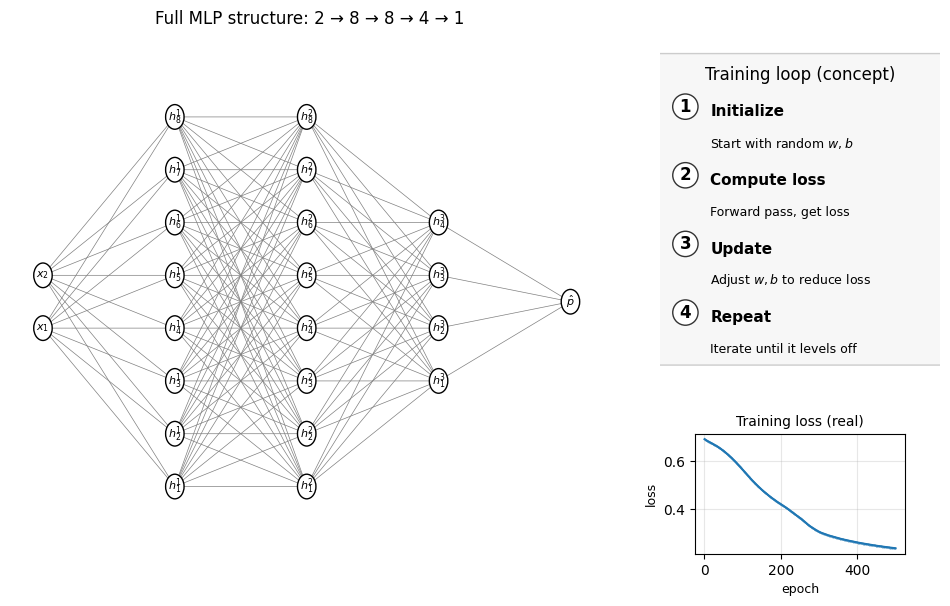

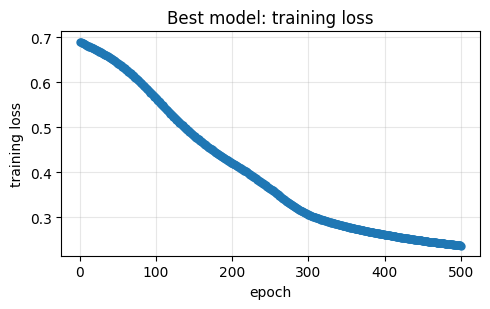

In [14]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score


def make_layer_choices(n_choices=20, min_layers=2, max_layers=5,
                       min_units=4, max_units=32, step=4, seed=0):
    rng = np.random.RandomState(seed)
    all_units = list(range(min_units, max_units + 1, step))

    choices = set()
    # Handful of sensible fixed patterns to ensure variety
    fixed = [
        (6,6), (6,3), (8,4),
        (8,8,4), (8,6,3), (16,8,4),
        (5,8,4,2), (8,6,6,3),
        (8,3,6,6,3), (5,8,8,6,3)
    ]
    for tpl in fixed:
        if min_layers <= len(tpl) <= max_layers:
            choices.add(tpl)
            if len(choices) == n_choices:
                return list(choices)

    # Randomly generate more until we hit n_choices
    while len(choices) < n_choices:
        L = rng.randint(min_layers, max_layers + 1)
        # Start wider, then non-increasing to keep shapes reasonable
        first = rng.choice(all_units)
        units = [first]
        for _ in range(L - 1):
            allowed = [u for u in all_units if u <= units[-1]]
            units.append(int(rng.choice(allowed)))
        choices.add(tuple(units))
    return list(choices)

def run_mlp_grid_search(Xtr, ytr, Xte, yte, layer_choices=None, lr_choices=None):
    if layer_choices is None:
        layer_choices = make_layer_choices(n_choices=20, seed=0)
    if lr_choices is None:
        lr_choices = [0.001, 0.01, 0.02, 0.05]

    base_mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(
            activation="relu",
            solver="adam",
            early_stopping=False, # keep early_stopping off to match direct fits, will take less time to run if turn on
            max_iter=500,    
            random_state=0
        ))
    ])

    param_grid = {
        "clf__hidden_layer_sizes": layer_choices,
        "clf__learning_rate_init": lr_choices,
    }




    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    gs = GridSearchCV(
        estimator=base_mlp,
        param_grid=param_grid,
        scoring="accuracy",
        n_jobs=-1,
        cv=cv,
        refit=True,
        verbose=1
    )

    gs.fit(Xtr, ytr)

    best_pipe = gs.best_estimator_
    best_params = gs.best_params_
    acc_train = accuracy_score(ytr, best_pipe.predict(Xtr))
    acc_test  = accuracy_score(yte, best_pipe.predict(Xte))

    # Build a tidy results DataFrame
    cols = ["mean_test_score", "std_test_score", "rank_test_score"]
    df = pd.DataFrame({
        "hidden_layer_sizes": [p["clf__hidden_layer_sizes"] for p in gs.cv_results_["params"]],
        "learning_rate_init": [p["clf__learning_rate_init"] for p in gs.cv_results_["params"]],
        "mean_test_score": gs.cv_results_["mean_test_score"],
        "std_test_score": gs.cv_results_["std_test_score"],
        "rank_test_score": gs.cv_results_["rank_test_score"],
    }).sort_values("mean_test_score", ascending=False).reset_index(drop=True)

    print("\nBest CV accuracy:", f"{gs.best_score_:.3f}")
    print("Best params:", best_params)
    print("Train accuracy (refit best):", f"{acc_train:.3f}")
    print("Test  accuracy (refit best):", f"{acc_test:.3f}")
    display(df.head(10))  # top 10; remove or change to show all
    return best_pipe, df

# Run the search
layer_choices = make_layer_choices(n_choices=20, seed=0)  # 2–5 layers, 20 combos
best_pipe, results_df = run_mlp_grid_search(Xtr, ytr, Xte, yte,
                                            layer_choices=layer_choices,
                                            lr_choices=[0.001, 0.01, 0.02, 0.05])

# Optional: diagram and loss curve for the best model
summarize_mlp(best_pipe)
draw_full_mlp_structure(best_pipe, Xtr)

best_clf = best_pipe.named_steps["clf"]
if hasattr(best_clf, "loss_curve_") and len(best_clf.loss_curve_) > 0:
    epochs = np.arange(1, len(best_clf.loss_curve_) + 1)
    plt.figure(figsize=(5,3.2))
    plt.plot(epochs, best_clf.loss_curve_, marker="o", markersize=5, linewidth=1.5)
    plt.xlabel("epoch"); plt.ylabel("training loss")
    plt.title("Best model: training loss")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

---

## 2. Neural nets for chemical property prediction

We reuse the same CSV from earlier lectures and compute four quick descriptors.

In [15]:
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_raw = pd.read_csv(url)
df_raw.head(3)

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10"
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10"


In [16]:
def calc_desc(smiles):
    if Chem is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    return pd.Series({
        "MolWt": Descriptors.MolWt(m),
        "LogP": Crippen.MolLogP(m),
        "TPSA": rdMolDescriptors.CalcTPSA(m),
        "NumRings": rdMolDescriptors.CalcNumRings(m)
    })

desc = df_raw["SMILES"].apply(calc_desc)
df = pd.concat([df_raw, desc], axis=1)
df[["Compound Name","SMILES","MolWt","LogP","TPSA","NumRings","Melting Point","Solubility_mol_per_L","Toxicity"]].head()

,Compound Name,SMILES,MolWt,LogP,TPSA,NumRings,Melting Point,Solubility_mol_per_L,Toxicity
0,"3,4-dihydro-1H-isochromene",c1ccc2c(c1)CCOC2,134.178,1.7593,9.23,2.0,65.8,0.103906,non_toxic
1,9H-fluorene,c1ccc2c(c1)Cc1ccccc1-2,166.223,3.2578,0.00,3.0,90.0,0.010460,toxic
2,"1,2,3,4-tetrahydronaphthalene",c1ccc2c(c1)CCCC2,132.206,2.5654,0.00,2.0,69.4,0.020589,toxic
3,ethylbenzene,CCc1ccccc1,106.168,2.2490,0.00,1.0,65.0,0.048107,non_toxic
4,cyclohexene,C1=CCCCC1,82.146,2.1166,0.00,1.0,96.4,0.060688,non_toxic


```{admonition} Reminder
We used these same descriptors in Lectures 5 to 7. They form a compact input vector for both regression and classification.
```




Neural nets are sensitive to feature scales. Always standardize inputs.

We will show MLP performance with and without `StandardScaler` on a quick regression target.

### 2.1 Target choice: melting point

In [17]:
df_reg = df[["MolWt","LogP","TPSA","NumRings","Melting Point"]].dropna()
X = df_reg[["MolWt","LogP","TPSA","NumRings"]].values
y = df_reg["Melting Point"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((460, 4), (115, 4))

MLP without scaling:

In [18]:
mlp_raw = MLPRegressor(hidden_layer_sizes=(64,32),
                       activation="relu",
                       learning_rate_init=0.01,
                       alpha=1e-4,
                       max_iter=1000,
                       random_state=0)
mlp_raw.fit(X_train, y_train)
y_pred_raw = mlp_raw.predict(X_test)
print(f"R2 no scaling: {r2_score(y_test, y_pred_raw):.3f}")

R2 no scaling: 0.867


MLP with scaling:

In [19]:
mlp_scaled = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", MLPRegressor(hidden_layer_sizes=(64,32),
                         activation="relu",
                         learning_rate_init=0.01,
                         alpha=1e-4,
                         max_iter=1000,
                         random_state=0))
])
mlp_scaled.fit(X_train, y_train)
y_pred_scaled = mlp_scaled.predict(X_test)
print(f"R2 with scaling: {r2_score(y_test, y_pred_scaled):.3f}")

R2 with scaling: 0.873


Parity plots to compare:

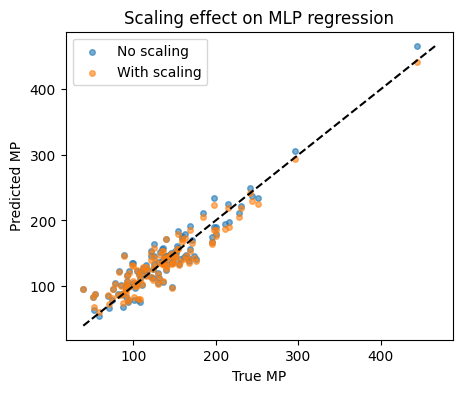

In [20]:
plt.figure(figsize=(5,4))
plt.scatter(y_test, y_pred_raw, s=16, alpha=0.6, label="No scaling")
plt.scatter(y_test, y_pred_scaled, s=16, alpha=0.6, label="With scaling")
lims = [min(y_test.min(), y_pred_raw.min(), y_pred_scaled.min()),
        max(y_test.max(), y_pred_raw.max(), y_pred_scaled.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True MP")
plt.ylabel("Predicted MP")
plt.title("Scaling effect on MLP regression")
plt.legend()
plt.show()

```{admonition} ⏰ **Exercises 2**

1. Try a single hidden layer `(32,)` and two layers `(128,64)`. Record R². Which is better here?
2. Change `alpha` to `1e-3` then `1e-2`. This is L2 regularization. How does it change test R² and the gap between train and test?
3. Set `early_stopping=True` and `validation_fraction=0.15`. Compare training time and R².
```


---



## 3. Regression with MLP on log-solubility

Solubility has a long tail. We saw in Lecture 5 that log transform helped.

### 3.1 Prepare data

In [21]:
df_sol = df.copy()
df_sol = df_sol[["MolWt","LogP","TPSA","NumRings","Solubility_mol_per_L"]].dropna()
df_sol["logS"] = np.log10(df_sol["Solubility_mol_per_L"] + 1e-6)

X = df_sol[["MolWt","LogP","TPSA","NumRings"]].values
y = df_sol["logS"].values

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=15)
Xtr[:3], ytr[:5]

(array([[174.243 ,   2.768 ,  17.07  ,   2.    ],
        [250.725 ,   3.6854,  26.3   ,   3.    ],
        [316.154 ,   3.2662,  46.17  ,   3.    ]]),
 array([-1.33079381, -1.81944953, -1.66573637, -1.73461148, -1.83886568]))

### 3.2 Build the pipeline and fit

We start small then expand.

In [22]:
reg1 = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(hidden_layer_sizes=(32,),
                         activation="relu",
                         learning_rate_init=0.01,
                         alpha=1e-3,
                         max_iter=1000,
                         random_state=0))
])
reg1

,steps,"[('scaler', ...), ('mlp', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,loss,'squared_error'
,hidden_layer_sizes,"(32,)"
,activation,'relu'
,solver,'adam'


Note: You can click on MLPRehressor above to see the details.


### 3.3 Parity and training curve
`MLPRegressor` exposes `loss_curve_` after fit. This is the average loss per epoch on the training data.

Compare with lasso (optimized with `alpha = 0.1`) we learned in Lecture 5, you can see its performance is better even without optimizing the hyperparameters.

In [23]:
reg1.fit(Xtr, ytr)
yhat = reg1.predict(Xte)

print(f"MSE: {mean_squared_error(yte, yhat):.4f}")
print(f"MAE: {mean_absolute_error(yte, yhat):.4f}")
print(f"R2:  {r2_score(yte, yhat):.3f}")

MSE: 0.0185
MAE: 0.1075
R2:  0.966


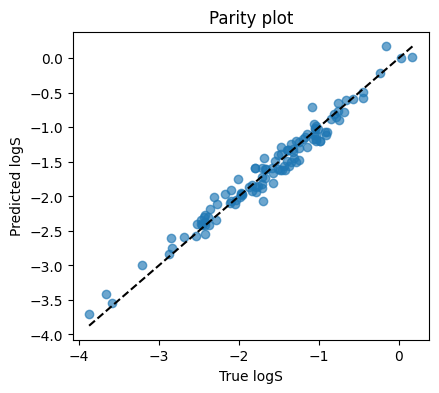

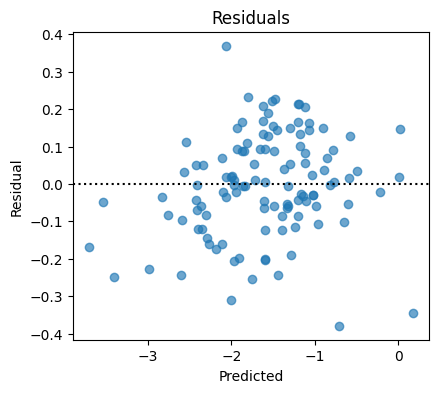

In [24]:
plt.figure(figsize=(4.6,4))
plt.scatter(yte, yhat, alpha=0.65)
lims = [min(yte.min(), yhat.min()), max(yte.max(), yhat.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True logS")
plt.ylabel("Predicted logS")
plt.title("Parity plot")
plt.show()

resid = yte - yhat
plt.figure(figsize=(4.6,4))
plt.scatter(yhat, resid, alpha=0.65)
plt.axhline(0, color="k", linestyle=":")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residuals")
plt.show()

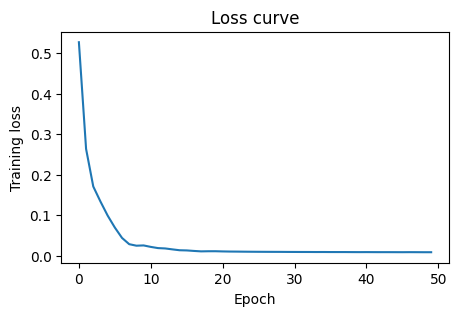

In [25]:
mlp_reg = reg1.named_steps["mlp"]
plt.figure(figsize=(5,3))
plt.plot(mlp_reg.loss_curve_)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.title("Loss curve")
plt.show()

---

## 4. Classification with MLP on toxicity

Moving beyond regression, let's look an example on the classification.

We will predict `toxic` vs `non_toxic` from the same four descriptors.

### 4.1 Prepare labels and build classifier

In [26]:
df_clf = df[["MolWt","LogP","TPSA","NumRings","Toxicity"]].dropna()
label_map = {"toxic":1, "non_toxic":0}
y = df_clf["Toxicity"].str.lower().map(label_map).astype(int).values
X = df_clf[["MolWt","LogP","TPSA","NumRings"]].values

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


clf_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(hidden_layer_sizes=(16,),
                          activation="relu",
                          learning_rate_init=0.01,
                          max_iter=2000,
                          random_state=0))
])
clf_pipe

,steps,"[('scaler', ...), ('mlp', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,hidden_layer_sizes,"(16,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001


Everything stays the same except we use `MLPClassifier()` instead of `MLPRegressor()`

Now let's fit and evaluate.

Accuracy:  0.939
Precision: 0.968
Recall:    0.958
F1:        0.963
AUC:       0.986


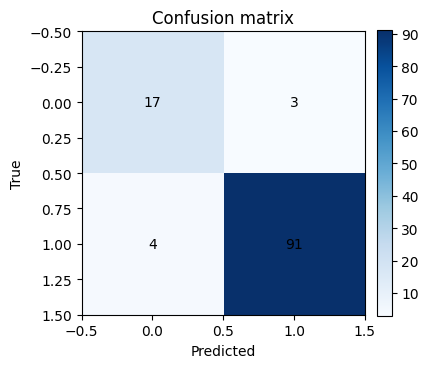

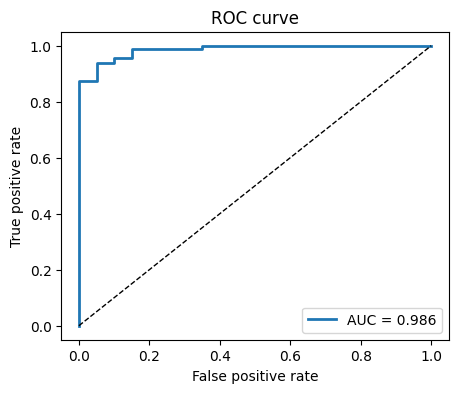

In [27]:
clf_pipe.fit(Xtr, ytr)
yp = clf_pipe.predict(Xte)
yproba = clf_pipe.predict_proba(Xte)[:,1]

acc  = accuracy_score(yte, yp)
prec = precision_score(yte, yp)
rec  = recall_score(yte, yp)
f1   = f1_score(yte, yp)
auc  = roc_auc_score(yte, yproba)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1:        {f1:.3f}")
print(f"AUC:       {auc:.3f}")

cm = confusion_matrix(yte, yp)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

fpr, tpr, thr = roc_curve(yte, yproba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], "k--", lw=1)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend()
plt.show()

Threshold tuning demo.

In [28]:
for t in [0.3, 0.5, 0.7]:
    yp_t = (yproba >= t).astype(int)
    print(f"threshold={t:.2f}  acc={accuracy_score(yte, yp_t):.3f}  prec={precision_score(yte, yp_t):.3f}  rec={recall_score(yte, yp_t):.3f}")

threshold=0.30  acc=0.965  prec=0.969  rec=0.989
threshold=0.50  acc=0.939  prec=0.968  rec=0.958
threshold=0.70  acc=0.930  prec=0.978  rec=0.937


---

## 5. Peek inside the network

While scikit-learn MLP is a black box in training, you can still inspect weights.

We will look at the first layer weights for regression on log-solubility and see which descriptors each hidden unit is sensitive to.

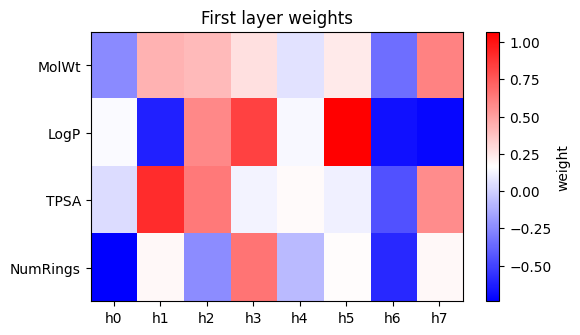

In [29]:
reg_inspect = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(hidden_layer_sizes=(8,),
                         activation="tanh",
                         learning_rate_init=0.01,
                         alpha=1e-3,
                         max_iter=1500,
                         random_state=0))
]).fit(Xtr, ytr)

W1 = reg_inspect.named_steps["mlp"].coefs_[0]  # shape (4, 8)
cols = ["MolWt","LogP","TPSA","NumRings"]

plt.figure(figsize=(6,3.5))
plt.imshow(W1, aspect="auto", cmap="bwr")
plt.yticks(range(len(cols)), cols)
plt.xticks(range(W1.shape[1]), [f"h{j}" for j in range(W1.shape[1])])
plt.colorbar(label="weight")
plt.title("First layer weights")
plt.show()

How to read above plot:

Each column is a hidden unit. Positive weights mean the unit activates when that feature is larger than average. Negative weights mean the opposite. This is not a full explanation, but it gives a flavor of what the network latches onto.

```{admonition} ⏰ **Exercises 5**

Try to overwrite the `Xtr`, `ytr` with different task (e.g. melting point regression, solubility regression, toxicity classification) and use different MLP to see the difference. 
```
---

## 6. Overfitting, regularization, and early stopping

Neural nets can overfit small chemistry tables. Two easy controls:

- **L2 penalty** via `alpha`. Larger alpha shrinks weights.
- **Early stopping** stops when validation score stops improving.

We will show a sweep of `alpha` for log-solubility.

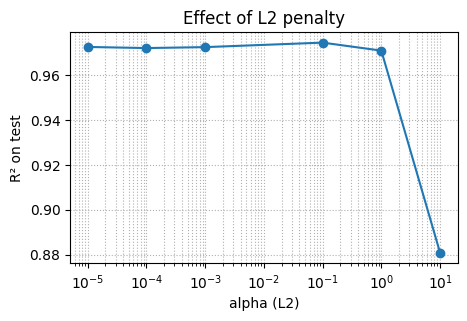

In [30]:
#reload and overwrite solubility training set
X = df_sol[["MolWt","LogP","TPSA","NumRings"]].values
y = df_sol["logS"].values

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=0)

alphas = [1e-5, 1e-4, 1e-3, 1e-1, 1, 10]
scores = []
for a in alphas:
    reg = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(hidden_layer_sizes=(32,),
                             activation="relu",
                             learning_rate_init=0.01,
                             alpha=a,
                             early_stopping=True,
                             validation_fraction=0.15,
                             max_iter=3000,
                             random_state=0))
    ])
    reg.fit(Xtr, ytr)
    yhat = reg.predict(Xte)
    scores.append(r2_score(yte, yhat))

pd.DataFrame({"alpha": alphas, "R2": np.round(scores, 4)})

plt.figure(figsize=(5,3))
plt.semilogx(alphas, scores, marker="o")
plt.xlabel("alpha (L2)")
plt.ylabel("R² on test")
plt.title("Effect of L2 penalty")
plt.grid(True, which="both", linestyle=":")
plt.show()

## 7. Moving forward with PyTorch

In [31]:
try:
    import torch, torch.nn as nn, torch.utils.data as tud
    from torch.utils.data import Dataset, DataLoader
except Exception:
    try:
        %pip install torch --quiet
    except Exception as e:
        print("If torch is missing, install it in your environment: pip install torch")
    import torch, torch.nn as nn, torch.utils.data as tud

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

^C


Note: you may need to restart the kernel to use updated packages.


```{admonition} Why switch to PyTorch
You already trained MLPs in scikit-learn. PyTorch lets you write the math yourself: define a model, pick a loss, run a loop that updates weights. This gives you more control and helps you understand what is happening.
```


Every PyTorch project has three parts:

1. **Model**: stack of layers with weights and activations.  
2. **Loss**: a number telling how far predictions are from the truth.  
3. **Optimizer**: an algorithm that adjusts weights to reduce loss.

We will start with regression on `logS`, then show a small classification task.  
Each step has short code and a plot so you can follow.


### 7.1 Prepare data for regression

We use descriptors `[MolWt, LogP, TPSA, NumRings]` to predict `logS`.  
Scaling is important for neural nets, so we apply `StandardScaler`.

In [ ]:
X = df_sol[["MolWt","LogP","TPSA","NumRings"]].values.astype(np.float32)
y = df_sol["logS"].values.astype(np.float32).reshape(-1,1)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=15)
scaler = StandardScaler().fit(X_tr)
X_tr_s, X_te_s = scaler.transform(X_tr), scaler.transform(X_te)
X_tr_s[:3], X_te_s[:3] 

---

### 7.2 Build a tiny network

Now we will start to build a network has one hidden layer of 32 units with ReLU activation.  
Output is a single number (regression).

This is equivalent to what we did before with:

> MLPRegressor(hidden_layer_sizes=(32,), activation="relu")


But the difference is that in scikit-learn the whole pipeline is hidden inside one class.

In PyTorch we build the pieces ourselves: the layers, the activation, and the forward pass.

This way you can see what is happening under the hood.

**How PyTorch models work**  
- A model is a Python object with **layers**. Each layer has **parameters** (weights and bias).  
- You pass an input **tensor** through the model to get predictions. This call is the **forward pass**.  
- PyTorch **records** operations during the forward pass. That record lets it compute **gradients** during `loss.backward()`.  
- Parameters live in `model.parameters()` and can be saved with `model.state_dict()`.  
- `.to(device)` moves the model to GPU if available. Inputs must be on the same device.

**Two common ways to build a model**  
1) **`nn.Sequential`**: fast for simple stacks.  
2) **Subclass `nn.Module`**: gives you a custom `forward` method and more control.

Below we show both styles. Pick one. They behave the same here.

In [ ]:
# Sequential style: quickest for simple feed-forward nets
in_dim = X_tr_s.shape[1]
reg_model = nn.Sequential(
    nn.Linear(in_dim, 32),  # weights W: [in_dim, 32], bias b: [32]
    nn.ReLU(),
    nn.Linear(32, 1)        # weights W: [32, 1], bias b: [1]
)
reg_model 


In [ ]:
# Inspect shapes of parameters
for name, p in reg_model.named_parameters():
    print(f"{name:20s}  shape={tuple(p.shape)}  requires_grad={p.requires_grad}")

A custom module version looks like this:

In [ ]:
class TinyRegressor(nn.Module):
    def __init__(self, in_dim, hidden=32):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)  # input -> hidden layer
        self.act = nn.ReLU()  # ReLU activation function in hidden layer
        self.fc2 = nn.Linear(hidden, 1)   # hidden -> output layer
    def forward(self, x):
        # x has shape [batch, in_dim]
        h = self.act(self.fc1(x))  # shape [batch, hidden]
        out = self.fc2(h)          # shape [batch, 1]
        return out

reg_model2 = TinyRegressor(in_dim, hidden=32)
reg_model2

**Shapes to keep in mind**  
- Input batch `x`: `[batch, in_dim]`  
- Hidden layer output: `[batch, 32]`  
- Final output: `[batch, 1]`

**Tip**: you can print a few predictions to sanity check the flow (numbers will be random before training).

In [ ]:
x_sample = torch.from_numpy(X_tr_s[:3])
with torch.no_grad():
    print("Raw outputs using first 3 values on X-train:", reg_model(x_sample).cpu().numpy().ravel())

For the rest of this chapter, we will use method 2 (`reg_model2`) to show the rest steps.

---

### 7.3 Loss and optimizer

For regression we use **MSELoss**.  
The optimizer is **Adam**, which updates weights smoothly.

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(reg_model2.parameters(), lr=1e-2, weight_decay=1e-3)
optimizer 

---

### 7.4 One training step demo

To see the loop clearly: forward → loss → backward → update.

In [ ]:
xb = torch.from_numpy(X_tr_s[:64])
yb = torch.from_numpy(y_tr[:64])

pred = reg_model2(xb)      # forward pass
loss = loss_fn(pred, yb)  # compute loss

optimizer.zero_grad()     # clear old grads
loss.backward()           # compute new grads for each parameter
optimizer.step()          # apply the update

float(loss.item())

---

### 7.5 Training loop

We train for 150 epochs. Each epoch goes through the dataset in batches.  
We plot the loss to see if the model is learning.

In [ ]:
class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(NumpyDataset(X_tr_s, y_tr), batch_size=64, shuffle=True)

train_losses = []
reg_model2.train()
for epoch in range(150):
    batch_losses = []
    for xb, yb in train_loader:
        xb, yb = xb, yb
        pred = reg_model2(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        batch_losses.append(loss.item())
    train_losses.append(np.mean(batch_losses))

plt.figure(figsize=(5,3))
plt.plot(train_losses)
plt.xlabel("epoch"); plt.ylabel("train MSE")
plt.title("Training loss - regression")
plt.grid(alpha=0.3)
plt.show()

Let’s break down what happened above step by step:

1. **Dataset and DataLoader**  
   We wrapped our numpy arrays in `NumpyDataset`, which makes them look like a PyTorch dataset.  
   Then `DataLoader` split the dataset into mini-batches of 64 rows and shuffled them each epoch.  
   This helps training be faster and more stable.

2. **Epochs and batches**  
   Each `epoch` means "one full pass over the training data".  
   Inside each epoch, we looped over mini-batches. For every batch:
   - We ran the **forward pass**: `pred = reg_model(xb)`
   - We computed the **loss**: `loss = loss_fn(pred, yb)`
   - We reset old gradients with `optimizer.zero_grad()`
   - We called `loss.backward()` so PyTorch computes gradients for each weight
   - We called `optimizer.step()` to update the weights slightly

3. **Loss tracking**  
   We stored the average loss per epoch in `train_losses`.  
   If you plot `train_losses`, you should see it go down.  
   This means the network predictions are getting closer to the true labels.


By the end of 150 epochs, the model should be much better than at the start.

---

### 7.6 Evaluate regression

We check mean squared error and plot predicted vs true `logS`.

In [ ]:
reg_model2.eval()
with torch.no_grad():
    yhat_te = reg_model2(torch.from_numpy(X_te_s)).cpu().numpy()

from sklearn.metrics import mean_squared_error, r2_score
print("MSE:", mean_squared_error(y_te, yhat_te))
print("R2:", r2_score(y_te, yhat_te))

plt.figure(figsize=(4.6,4))
plt.scatter(y_te, yhat_te, alpha=0.6)
lims = [min(y_te.min(), yhat_te.min()), max(y_te.max(), yhat_te.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True logS"); plt.ylabel("Pred logS")
plt.title("Parity plot")
plt.show()

This suggests our customized NN achieve a good performance on this task  :D

---

## 8. Glossary

```{glossary}
multilayer perceptron
  A network of layers that apply linear transforms plus nonlinear activations.

activation
  Nonlinear function applied elementwise. Common choices: ReLU, tanh, logistic.

loss
  A number that measures how wrong the predictions are on training data.

optimizer
  Method that updates weights to reduce loss. Scikit-learn uses variants of SGD or LBFGS under the hood.

alpha
  L2 penalty strength in scikit-learn MLP. Larger means more shrinkage.

early stopping
  Stop training when validation score does not improve for a patience window.

scaling
  Standardize features to zero mean and unit variance. Critical for neural nets.

parity plot
  Scatter of predicted vs true values for regression.

ROC AUC
  Area under the Receiver Operating Characteristic curve. Threshold free ranking metric.

hidden layer
  A layer between input and output that lets the model learn nonlinear combinations.
```



---

## 9. Quick reference

```{admonition} Recipes
- Always scale inputs for MLPs: `Pipeline([("scaler", StandardScaler()), ("mlp", ...)])`
- Start small: one hidden layer with 16 to 64 units
- For regression: check parity and residual plots
- For classification: look at confusion matrix and ROC
- To avoid overfitting: increase `alpha` and use `early_stopping=True`
- Reproducibility: set `random_state`
```

```{admonition} Common args
- `hidden_layer_sizes=(h1, h2, ...)` number of units per layer
- `activation="relu"` or `"tanh"`
- `alpha` L2 penalty, try 1e-5 to 1e-2
- `learning_rate_init` step size, try 0.001 to 0.05
- `max_iter` cap on epochs
- `early_stopping=True` and `validation_fraction=0.1 to 0.2`
```

---

## 10. In-class activity



### Q1. Tiny MLP for melting point

- Use features `[MolWt, LogP, TPSA, NumRings]`
- Split 80/20 with `random_state=7`
- Train `MLPRegressor` with `(32,)`, `alpha=1e-3`, ReLU
- Report `MSE`, `MAE`, `R²` and draw a parity plot

```python
# Q1 starter
df_reg = df[["MolWt","LogP","TPSA","NumRings","Melting Point"]].dropna()
X = df_reg[["MolWt","LogP","TPSA","NumRings"]].values
y = df_reg["Melting Point"].values

Xtr, Xte, ytr, yte = train_test_split(...) #TO DO

pipe = Pipeline(...).fit(Xtr, ytr)  #TO DO

yhat = pipe.predict(Xte)
print(f"MSE={mean_squared_error(yte,yhat):.2f}  MAE={mean_absolute_error(yte,yhat):.2f}  R2={r2_score(yte,yhat):.3f}")

plt.figure(figsize=(4.5,4))
plt.scatter(yte, yhat, alpha=0.65)
lims = [min(yte.min(), yhat.min()), max(yte.max(), yhat.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True MP"); plt.ylabel("Pred MP"); plt.title("Q1 parity")
plt.show()
```

### Q2. Depth vs width on log-solubility

- Train three models on `logS` with hidden sizes `(16,)`, `(32,)`, `(64,32)`
- Keep `alpha=1e-3`, `learning_rate_init=0.01`, early stopping on
- Compare test `R²` and show the three loss curves on the same plot

```python
# Q2 starter

df_sol = df[["MolWt","LogP","TPSA","NumRings","Solubility_mol_per_L"]].dropna().copy()
df_sol["logS"] = np.log10(df_sol["Solubility_mol_per_L"]+1e-6)
X = df_sol[["MolWt","LogP","TPSA","NumRings"]].values
y = df_sol["logS"].values

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=15)

sizes = [...] #TO DO
r2s, curves = [], []


for sz in sizes:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(hidden_layer_sizes=sz, activation="relu",
                             alpha=...,  #TO DO
                             learning_rate_init=...,  #TO DO
                             early_stopping=..., #TO DO 
                             validation_fraction=0.15,
                             max_iter=3000, random_state=0))
    ]).fit(Xtr, ytr)
    yhat = pipe.predict(Xte)
    r2s.append(r2_score(yte, yhat))
    curves.append(pipe.named_steps["mlp"].loss_curve_)

print(pd.DataFrame({"hidden_sizes":[str(s) for s in sizes],"R2":np.round(r2s,3)}))

plt.figure(figsize=(5.5,3.5))
for sz, c in zip(sizes, curves):
    plt.plot(c, label=str(sz))
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Q2 loss curves")
plt.legend(); plt.show()
```

### Q3. Toxicity classification with threshold tuning

- Train `MLPClassifier` with `(32,)`, `alpha=1e-3`, early stopping on
- Compute probabilities on test
- For thresholds `[0.3, 0.5, 0.7]` print Accuracy, Precision, Recall, F1

```python
# Q3 starter
#TO DO
```

### Q4. Compare MLP to Linear Regression on logS

- Same train test split as Q2
- Fit Linear Regression on scaled inputs
- Report both R² on test and draw both parity scatters on one plot

```python
# Q4 starter
#TO DO
```

### Q5. Stability across seeds

- Use features `[MolWt, LogP, TPSA, NumRings]`

- Target for property `Melting Point` 

- Split 80/20 with random_state=15

- Standardize inputs

- Build a **PyTorch** NN with hidden sizes (32, 16) and ReLU

- Train 200 epochs, batch size 64, MSELoss, Adam(lr=1e-3, weight_decay=1e-3)

- Report MSE, MAE, R² and draw a parity plot

```python
# Q5 starter
df_mp = df[["MolWt","LogP","TPSA","NumRings","Melting Point"]].dropna().copy()

X = df_mp[["MolWt","LogP","TPSA","NumRings"]].values.astype(np.float32)
y = df_mp["Melting Point"].values.astype(np.float32).reshape(-1,1)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=15)
scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr).astype(np.float32)
Xte_s = scaler.transform(Xte).astype(np.float32)

class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(NumpyDataset(Xtr_s, ytr), batch_size=64, shuffle=True)

in_dim = Xtr_s.shape[1]
model = nn.Sequential(
... # TO DO
)
# Note: You can also use Method 2 we discussed.

loss_fn = nn.MSELoss()
opt = ... # TO DO

train_losses = []
model.train()
for epoch in range(200):
    batch_losses = []
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        batch_losses.append(loss.item())
    train_losses.append(np.mean(batch_losses))

# Evaluate
model.eval()
with torch.no_grad():
    yhat = model(torch.from_numpy(Xte_s)).numpy()

print(f"MSE: {mean_squared_error(yte, yhat):.3f}")
print(f"MAE: {mean_absolute_error(yte, yhat):.3f}")
print(f"R2:  {r2_score(yte, yhat):.3f}")

# Learning curve
plt.figure(figsize=(5,3))
plt.plot(train_losses)
plt.xlabel("epoch"); plt.ylabel("train MSE"); plt.title("Training loss (melting point)")
plt.grid(alpha=0.3)
plt.show()

# Parity plot
plt.figure(figsize=(4.6,4))
plt.scatter(yte, yhat, alpha=0.65)
lims = [min(yte.min(), yhat.min()), max(yte.max(), yhat.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True MP"); plt.ylabel("Pred MP"); plt.title("Parity plot (PyTorch MP)")
plt.show()

```